学习资料：https://www.bilibili.com/video/BV1PX4y1g7KC?p=3&spm_id_from=pageDriver
# 线性回归

可以看成单层神经网络

## 小批量随机梯度下降

随机采样b个样本来近似损失

b就是批量大小：batch

* 重要超参数：
    1. batch
    2. 学习率

## 线性回归的从零开始实现

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 生成带有噪声的数据集
* synthetic_data:合成数据
* torch.matmul 矩阵相乘

features: tensor([-1.6281, -0.7288]) 
label: tensor([3.4074])


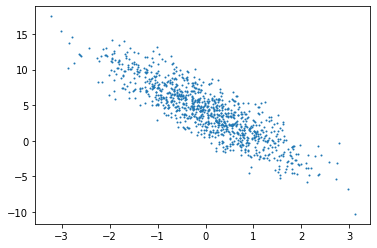

In [2]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w))) # 标准正态分布，n行特征数列
    y = torch.matmul(X, w) + b # matmul 矩阵相乘
    y += torch.normal(0, 0.01, y.shape)
    return X,y.reshape((-1, 1)) # (-1, 1)的意思是管你多少行，我只要一列
                                 # 不转一下可能不区分行列

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:',features[0],'\nlabel:',labels[0])
d2l.plt.scatter(features[:, 1].detach().numpy(), # detach分离梯度
               labels.detach().numpy(),1); # # 加个1变得更加细，不知道是不是自动调整散点大小

<font color = 'red'>加个1变得更加细，不知道是不是自动调整散点大小</font>

### 定义一个`data_iter`函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量

* <font color = 'red'>注意这里`yield`的用法，迭代器函数用

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples)) # 定义一个全体索引
    # 这些样本是随机读取的，没有特定的顺序
    
    random.shuffle(indices) # 打乱列表
    for i in range(0, num_examples, batch_size): # range(a,b,c)：用c把a到b平均切开
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)]) 
        # 定义一个批量中的索引把原来已经打乱的索引切割成batch_size的大小
        # 用min来防止最后一个超出
        yield features[batch_indices], labels[batch_indices]
        
batch_size = 10
        
for X, y in data_iter(batch_size, features, labels):
    print(X,'\n', y)
    break

tensor([[-0.2218,  0.7675],
        [-0.0719,  1.3527],
        [-2.4878,  0.2124],
        [-0.7748,  1.5608],
        [-0.6944,  0.0721],
        [-0.3395,  0.2583],
        [ 0.7671, -1.2272],
        [-1.3572,  0.8241],
        [ 1.1674,  0.2094],
        [ 0.1687,  0.3197]]) 
 tensor([[ 1.1598],
        [-0.5327],
        [-1.5036],
        [-2.6534],
        [ 2.5520],
        [ 2.6435],
        [ 9.8775],
        [-1.3231],
        [ 5.8171],
        [ 3.4667]])


`lr`：learning rate，学习率

### 模块函数定义

In [31]:
w = torch.normal(0, 0.01, size = (2, 1), requires_grad = True)
b = torch.zeros(1, requires_grad = True)

def linreg(X, w, b):
    '''线性回归模型'''
    return torch.matmul(X, w) + b
    # 返回的是y

def squared_loss(y_hat, y):
    '''均方误差。'''
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):
    '''SGD小批量随机梯度下降'''
    with torch.no_grad():
        '''更新的时候不需要参与梯度计算'''
        for param in params:
            param -= lr * param.grad / batch_size # 除掉了mse中没有除的样本量
            # 梯度下降，注意这里用的是-=
            param.grad.zero_()

### 训练过程
* 注意这里的命名和循环可以很方便的换成其他损失和模型以及参数
* `with torch.no_grad():`反正不需要计算梯度就套上就行了，目前用到这个的地方：
    1. SGD更新参数时，不需要计算梯度
    2. 每一个epoch中评价进度时，不需要计算梯度

In [32]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 注意sgd定义中params要是一个可迭代格式
        
    with torch.no_grad():
        '''这一段是为了评价进度而产生的，不需要计算梯度'''
        train_l = loss(net(features, w, b), labels)
        print(f'epoch{epoch + 1}, loss{float(train_l.mean()): f}')
        # 注意这里loss要算平均才是mse

epoch1, loss 0.037776
epoch2, loss 0.000140
epoch3, loss 0.000054
w的估计误差：tensor([ 0.0003, -0.0004], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0010], grad_fn=<RsubBackward1>)


In [34]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([ 0.0003, -0.0004], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0010], grad_fn=<RsubBackward1>)


## 线性回归的简洁实现

In [38]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 调用框架中现有的API来读取数据 

* 用到的几个函数
    1. `data.TensorDataset`
    
        TensorDataset 可以用来对 tensor 进行打包，就好像 python 中的 zip 功能。该类通过每一个 tensor 的第一个维度进行索引。因此，该类中的 tensor 第一维度必须相等. 另外：TensorDataset 中的参数必须是 tensor
        <font color = 'red'>这里的*是干嘛的？拆包用的</font>
    2. ` data.DataLoader`

        DataLoader就是用来包装所使用的数据，每次抛出一批数据

In [124]:
def load_array(data_arrays, batch_size, is_train = True):
    '''构建一个PyTorch数据迭代器
        打包+输出一批
    '''
    dataset = data.TensorDataset(*data_arrays)
    '''
        data = data.TensorDataset
        dataset是对features和labels经过打包的量
            是一个迭代器，每次输出一组
    '''
    return data.DataLoader(dataset, batch_size, shuffle = is_train)
    '''
        data.DataLoader输入一个迭代器同时也输出一个迭代器
            可以进行随机分批和打乱
            从数据库中每次抽出batch size个样本
    '''

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-1.2345, -0.1318],
         [-1.2722, -0.1912],
         [ 1.0967, -0.6428],
         [ 0.3520, -1.2896],
         [-0.5526,  0.5265],
         [-2.0606,  0.0271],
         [ 0.0254,  1.3917],
         [-0.3199,  0.4834],
         [ 2.1345,  1.1450],
         [ 1.4033, -0.5875]]),
 tensor([[ 2.1658e+00],
         [ 2.3026e+00],
         [ 8.5776e+00],
         [ 9.2997e+00],
         [ 1.3060e+00],
         [-3.3099e-03],
         [-5.0388e-01],
         [ 1.8934e+00],
         [ 4.5706e+00],
         [ 9.0063e+00]])]

In [128]:
type(*(features, labels))

TypeError: type() takes 1 or 3 arguments

In [137]:
(([1,2,3]))

[1, 2, 3]